https://pytorch.org/tutorials/beginner/introyt/trainingyt.html <br>
Instalar: torch, torchvision, tensorboard, matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import torch
import torchvision
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import torch.nn as nn
import torch.nn.functional as F

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [4]:
#torch.multiprocessing.set_sharing_strategy('file_system')

In [5]:
#Define a transform object that takes the data to pytorch tensor form and normalizes it
transform = Compose( [ToTensor(), Normalize((0.5,),(0.5,))] );

In [6]:
#Get the fashion mnist set of images, and create the train and test data sets
training_set = FashionMNIST('./data', train=True, transform=transform, download=True);
validation_set = FashionMNIST('./data', train=False, transform=transform, download=True);

In [7]:
#Prepare batches that update at every epoch for training. Use multiprocessing
training_loader = DataLoader(training_set, batch_size=4, shuffle=True, num_workers=4);
validation_loader = DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=4);

In [8]:
#Define class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot');

In [9]:
#Report split sizes
print('Training set has {} instances'.format(len(training_set)));
print('Validation set has {} instances'.format(len(validation_set)));

Training set has 60000 instances
Validation set has 10000 instances


## Visualization

In [10]:
#Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1,2,0)))

In [11]:
#Create an iterator to go through the training data
dataiter = iter(training_loader);
#Take the next minibatch of data
images, labels = dataiter.next(); 

In [15]:
images.shape

torch.Size([4, 1, 28, 28])

Ankle Boot Dress Coat Ankle Boot


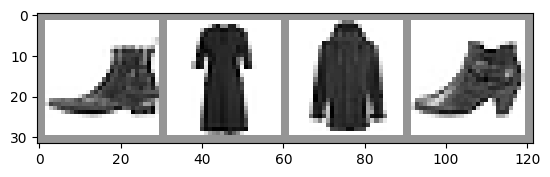

In [11]:
#Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images);
matplotlib_imshow(img_grid, one_channel=True);
print(' '.join(classes[labels[j]] for j in range(4)));

## The model

In [12]:
#pytorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) #Add a convolution layer thet resives a single layer as imput (grayscale), uses 6 filters on it, and each filter has 5x5 size
        self.pool = nn.MaxPool2d(2,2) #Pooling layer. Operation to get the max value over 2x2 (stride 2) sections the filter and reduce the number of features
        self.conv2 = nn.Conv2d(6, 16, 5) #Second convolution layer (6 chanel imput, from the 6 filters of previous layer, 16 filters, and 5x5 filter size)
        self.fc1 = nn.Linear(16*4*4, 120) #1st linear layer to classify the compressed features (why is imput 16*4*4?)
        self.fc2 = nn.Linear(120, 84) #2nd linear layer
        self.fc3 = nn.Linear(84, 10) #3rd linear layer. output is size 10 because there are 10 classes
        
    # Forward passing of the data
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # pass x input to conv layer 1 and apply relu to the result, then do pooling to reduce number of features?
        x = self.pool(F.relu(self.conv2(x))) # then do the same using conv layer 2?
        x = x.view(-1, 16*4*4) # flatten x from 2d to 1d??
        x = F.relu(self.fc1(x)) #Apply relu to output of linear layer 1
        x = F.relu(self.fc2(x)) #Apply relu to output of linear layer 2
        x = self.fc3(x) #Pass output through layer 3 and get final result
        return x


In [13]:
model = GarmentClassifier().to(device)

## Loss function

In [14]:
## use the log loss as cost function
loss_fn = nn.CrossEntropyLoss()

In [15]:
##Test the loss function##
#Pass data in batches of 4
#Returns 10 lists of 4 random numbers between 0 and 1 as a 4x10 tensor, to test confidence on each of the 10 classes
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the possible 10
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.2121, 0.9362, 0.5578, 0.7344, 0.3512, 0.6038, 0.4216, 0.5642, 0.3233,
         0.0842],
        [0.9853, 0.5706, 0.6851, 0.3900, 0.0514, 0.7254, 0.1338, 0.7979, 0.4026,
         0.6414],
        [0.2342, 0.1592, 0.3002, 0.1885, 0.3945, 0.5929, 0.9609, 0.9141, 0.7921,
         0.1575],
        [0.8892, 0.0035, 0.8286, 0.7205, 0.4870, 0.6235, 0.1152, 0.7101, 0.1267,
         0.6128]])
tensor([1, 5, 3, 7])
Total loss for this batxh: 2.201442241668701


## Optimizer

In [16]:
#Stochastic gradient descent optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training loop
- Get a batch of data from the Data Loader
- Zero the optimizer's gradients
- Gets predictions from the model for an imput batch
- Computes the loss function for the prediction
- Adjusts the model's weights with gradient descent
- Reports the loss for every 1000 batches
- Reports the average per-batch loss for the last 1000 batches for comparison to a validation run

In [17]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0
    last_loss = 0
    
    #Use an enumeration istead of an iterator to track the batch index and do reporting
    for i, data in enumerate(training_loader):
        #training instances are input + label pairs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        #zero the gradients
        optimizer.zero_grad()
        
        #make predictions fo this batch
        outputs = model(inputs)
        
        #compute loss and its gradient
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        #adjust the weights
        optimizer.step()
        
        #gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 #loss per batch
            print(' batch {} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0
            
    return last_loss

## Main loop
Before training an epoch there are a couple of things to do:
- Validate by checking the relative loss on a set of validation data and report it
- Save a copy of the model

We use TensorBoard to do the reporting.

In [18]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [19]:
EPOCHS = 5
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}'.format(epoch_number + 1))
    
    #Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    #To do reporting gradients do not need to be on
    model.train(False)
    
    #Pull batches fron validation data to validate
    running_vloss = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
    avg_vloss = running_vloss / (i+1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    
    ##Log the runnig loss averaged per batch for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                      {'Training': avg_loss, 'Validation': avg_vloss},
                      epoch_number + 1)
    writer.flush()
    
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        
    epoch_number += 1


EPOCH 1
 batch 1000 loss: 1.951608291476965
 batch 2000 loss: 0.9275175140351057
 batch 3000 loss: 0.7273635933492333
 batch 4000 loss: 0.6857061487929895
 batch 5000 loss: 0.6131813179627061
 batch 6000 loss: 0.5906636993456632
 batch 7000 loss: 0.5566314184907823
 batch 8000 loss: 0.5372800656049512
 batch 9000 loss: 0.5214024725520285
 batch 10000 loss: 0.4880351419025101
 batch 11000 loss: 0.49009572744584873
 batch 12000 loss: 0.47047942504368256
 batch 13000 loss: 0.44422325091611126
 batch 14000 loss: 0.45987637954414823
 batch 15000 loss: 0.4396483855495462
LOSS train 0.4396483855495462 valid 0.4576929211616516
EPOCH 2
 batch 1000 loss: 0.42819960145308866
 batch 2000 loss: 0.40572335118026237
 batch 3000 loss: 0.4200742274297081
 batch 4000 loss: 0.38785089648660503
 batch 5000 loss: 0.38698751975107004
 batch 6000 loss: 0.3783386030740221
 batch 7000 loss: 0.3850077346680337
 batch 8000 loss: 0.3982277583365794
 batch 9000 loss: 0.34711297449842093
 batch 10000 loss: 0.378470

## Predict

In [20]:
#To load the saved version of the model
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load('./model_20220915_203847_4'))

<All keys matched successfully>

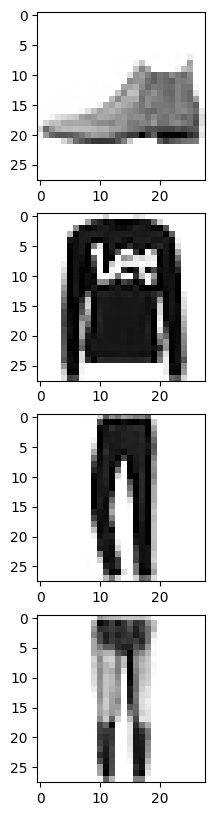

In [21]:
imgs, label = next(iter(validation_loader))
fig, ax = plt.subplots(4,1,figsize=(10,10))
count = 0
for img in imgs:
    #print(img.shape)
    npimg = img[0].numpy() / 2 + 0.5
    #print(npimg.shape)
    ax[count].imshow(npimg, cmap="Greys")
    count += 1

In [22]:
print(saved_model(imgs))
print(labels)

tensor([[ -2.1429,  -4.8371,  -4.4287,  -5.0371,  -4.9624,   4.7230,  -4.0712,
           6.7861,   0.3977,  13.4786],
        [ -0.1092,  -2.6957,  12.0830,  -2.3323,   6.1596,  -2.5262,   4.4185,
          -6.2944,  -1.4605,  -4.8854],
        [  2.9368,  25.9884,  -1.4896,   1.7077,   4.3552,  -6.4322,   2.4585,
         -11.5940,  -2.0809, -15.6228],
        [  2.8013,  24.1439,  -3.7177,   5.4292,   5.2264,  -7.8289,   1.5216,
          -9.8917,  -3.8166, -13.7506]], grad_fn=<AddmmBackward0>)
tensor([9, 3, 4, 9])
